In [1]:
####%%%%%!pip install autograd
########!pip install tensorflow

In [2]:
import tensorflow as tf
import autograd.numpy as np
from autograd import grad 
import autograd.numpy.random as npr
from autograd.core import primitive
from matplotlib import pyplot as plt
%matplotlib inline
import time


In [3]:
nx = 11
Tfinal=1
dx = Tfinal / (nx-1)

In [4]:
IC =100.
def A(x):
    '''Left part of initial equation    '''
    return 10.
def B(x):
    '''Right part of initial equation'''
    return 0.
def f(x, psy):
    '''d(psy)/dx = f(x, psy)This is f() function on the right'''
    return B(x) - psy * A(x)
def psy_analytic(x):
    ''' Analytical solution of current problem'''
    return np.exp(-10*x)*IC

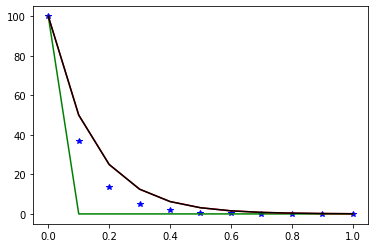

In [5]:
x_space = np.linspace(0, Tfinal, nx)    
y_space = psy_analytic(x_space)

psy_fd1 = np.zeros_like(y_space)
psy_fd1[0] = IC # IC
psy_fd2 = np.zeros_like(y_space)
psy_fd2[0] = IC # IC
psy_fd3 = np.zeros_like(y_space)
psy_fd3[0] = IC 
psy_fdd = np.zeros_like(y_space)

### first order
n=1
for i in range(1, len(x_space)):
    psy_fd1[i] = psy_fd1[i-1]  + dx*f(x_space[i-1],psy_fd1[i-1])
    
###  2nd order
# n=2
for i in range(1, len(x_space)):
    psy_fd2[i] = psy_fd2[i-1] + dx*f(x_space[i-1]+dx/2, psy_fd2[i-1]+dx*f(x_space[i-1],psy_fd2[i-1])/2)
    
for i in range(1, len(x_space)):
    psy_fdd[i] = psy_fd3[i-1]  + dx*f(x_space[i-1],psy_fd3[i-1])
    psy_fd3[i] = psy_fd3[i-1] + dx*(f(x_space[i-1],psy_fd3[i-1])+f(x_space[i],psy_fdd[i]))/2
psy_fd = psy_fd1
plt.figure()
plt.plot(x_space, y_space, 'b*')
plt.plot(x_space, psy_fd1, 'g')
plt.plot(x_space, psy_fd2, 'r')
plt.plot(x_space, psy_fd3, 'k')
plt.show()

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

def neural_network(W, x):
    a1 = sigmoid(np.dot(x, W[0]))
    return np.dot(a1, W[1])

def d_neural_network_dx(W, x, k=1):
    return np.dot(np.dot(W[1].T, W[0].T**k), sigmoid_grad(x))

def loss_function(W, x, yhat):
    loss_sum = 0
    for i in range(0,len(x)):
        net_out = neural_network(W, x[i])[0][0]
        psy_t = yhat[i] +  x[i]**(n+1)*net_out
        
        d_net_out = d_neural_network_dx(W, x[i])[0][0]
        d_psy_t = f(x[i],yhat[i])+ (n+1)*(x[i]**n)*net_out + x[i]**(n+1)* d_net_out
        func = f(x[i], psy_t)
        err_sqr = (d_psy_t - func)**2
        loss_sum += err_sqr
    return loss_sum


In [7]:
import time
from tqdm import tqdm

lmb = 0.001 # init : 0.001
samples = 1 # best result 개수

base_error = y_space - psy_fd
data = {'best_res_time' : [], 'break_average' : [], 'error_total' : [], 'bad_res' : 0, 'error_graph' : []}

while len(data['best_res_time']) != samples:
    time_start = time.perf_counter()
    W = [npr.randn(1, 10), npr.randn(10, 1)]
    
    data['error_graph'] = []
    for i in tqdm(range(5000), desc = '좋은 데이터 개수 {} / {}, 반복문 진행 상황 '.format(len(data['best_res_time']), samples), nrows = 0):
        loss_grad = grad(loss_function)(W, x_space,psy_fd)

        W[0] = W[0] - lmb * loss_grad[0]
        W[1] = W[1] - lmb * loss_grad[1]

        cnt = 0
        for xi in x_space:
            if neural_network(W, xi)[0] < 0:    # 1차 거르는 단계, 첫번째는 초반부에 음수값으로 자리 잡기 시작하면 좋은 데이터가 잘 안나옴.
                continue
            else:
                cnt += 1

        y_error = y_space - (psy_fd + [xi**(n+1)*neural_network(W, xi)[0][0] for xi in x_space])
        data['error_graph'].append((i, np.linalg.norm(y_error)))
        if cnt == len(x_space) and i > 100:
            e_cnt = 0
            for b_e, y_e in zip(base_error, y_error):
                if abs(b_e) < abs(y_e):
                    pass
                else:
                    e_cnt += 1
                        
            if e_cnt == len(y_error) and np.linalg.norm(y_error) < np.linalg.norm(base_error):   # 결과 값의 모든 에러가 베이스 에러보다 낮을 때 좋은 결과 데이터에 저장.
                data['best_res_time'].append(time.perf_counter() - time_start)
                data['break_average'].append(i)
                data['error_total'].append(np.linalg.norm(y_error))
                data['bad_res'] -= 1
                break

    data['bad_res'] += 1


좋은 데이터 개수 0 / 1, 반복문 진행 상황 :   8%|▊         | 388/5000 [00:03<00:45, 101.98it/s]


Text(0, 0.5, 'Error')

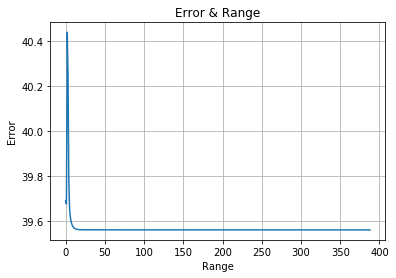

In [8]:
x = [x[0] for x in data['error_graph']]
y = [y[1] for y in data['error_graph']]
plt.plot(x, y)
plt.title('Error & Range')
plt.grid(b = True)
plt.xlabel('Range')
plt.ylabel('Error')

[array([0.00564135]), array([0.00418438]), array([0.00283336]), array([0.00168204]), array([0.00080222]), array([0.00023793]), array([4.19004605e-06]), array([8.97130973e-05]), array([0.00046235]), array([0.00107576]), array([0.00187602])]


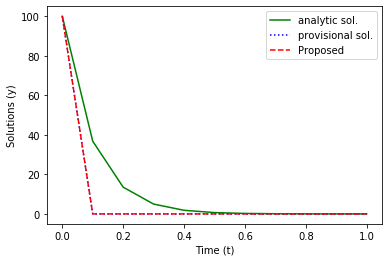

In [9]:
# tf.print(loss_function(W, x_space,psy_fd))
res =  psy_fd + [xi**(n+1)*neural_network(W, xi)[0][0] for xi in x_space]

aa= [neural_network(W, xi)[0] for xi in x_space]
print(aa)
beingsaved = plt.figure()
plt.plot(x_space, y_space, 'g-',label='analytic sol.') 
plt.plot(x_space, psy_fd, 'b:',label='provisional sol.')
plt.plot(x_space, res, 'r--',label='Proposed')
plt.xlabel('Time (t)')
plt.ylabel('Solutions (y)')
#plt.yscale("log")
plt.legend()
plt.show()
#beingsaved.savefig('test3comp.eps', format='eps', dpi=1000)

In [10]:
print(np.linalg.norm(y_space - res))
print(np.linalg.norm(y_space - psy_fd))

39.56220617570226
39.562310653835524


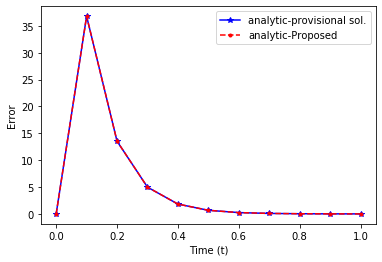

In [11]:
beingsaved1 = plt.figure()
plt.plot(x_space, abs(y_space-psy_fd), 'b*-',label='analytic-provisional sol.') 
plt.plot(x_space, abs(y_space-res), 'r.--',label='analytic-Proposed')
#plt.plot(x_space[1:], abs(y_space[1:]-psy_fd[1:]), 'b*-',label='analytic-provisional sol.') 
#plt.plot(x_space[1:], abs(y_space[1:]-res[1:]), 'r.--',label='analytic-Proposed')
plt.xlabel('Time (t)')
plt.ylabel('Error')
#plt.yscale("log")
plt.legend()
plt.show()
#beingsaved1.savefig('test3err.eps', format='eps', dpi=1000)

In [12]:
#print(y_space[1:]-psy_fd[1:])

In [13]:
time_elapsed = (time.perf_counter() - time_start)
# memMb=resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024.0/1024.0
print ("%5.1f secs" % (time_elapsed))
# print ("%5.1f secs %5.1f MByte" % (time_elapsed,memMb))

  4.4 secs
